In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import cv2
import time

from isingCA_local_connectivity import isingCA
import pygame

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from itertools import product

# toggle the brush between two modes (shortcut B)
BRUSH_TOGGLE = False

def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
     # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    # doesn't do periodic boundaries
    # state[:, 1, xcl - r:xcl + r, ycl - r : ycl + r] -= (blur.cuda() + 1e-6) 
    
    range_x = range(xcl - r, xcl + r)
    range_y = range(ycl - r, ycl + r)
    coords = list(product(range_x, range_y))
    idx_i = [c[0] % RESX for c in coords]
    idx_j = [c[1] % RESY for c in coords]
    
    if BRUSH_TOGGLE:
        state[:, 1, idx_i, idx_j] -= (blur.reshape(-1).cuda() + 1e-6) # change temp
    else:
        state[:, 0, idx_i, idx_j] = torch.where(rm.reshape(-1).cuda() <= 1.,
                                                1.,
                                                state[:, 0, idx_i, idx_j]
                                               )
    
    state[0, 1] = torch.clip(state[0, 1], 1e-6)

    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    range_x = range(xcl - r, xcl + r)
    range_y = range(ycl - r, ycl + r)
    coords = list(product(range_x, range_y))
    idx_i = [c[0] % RESX for c in coords]
    idx_j = [c[1] % RESY for c in coords]
    if BRUSH_TOGGLE:
        state[:, 1, idx_i, idx_j] += blur.reshape(-1).cuda()
    else:
        state[:, 0, idx_i, idx_j] = torch.where(rm.reshape(-1).cuda() <= 1.,
                                                -1.,
                                                state[:, 0, idx_i, idx_j]
                                               )
    
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), state.shape[1])
    
    return cdim_order
    
def WHEEL_beta(beta, direction):
    
    return beta + direction * 0.01

def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

In [3]:
def print_something(something):
    fps = f'{something:.3f}'
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf

# Test

In [4]:
RADIUS=5
BETA=1. / (RADIUS*RADIUS)
RES = (640, 640)
ca = isingCA(RES, BETA=BETA, RADIUS=RADIUS).cuda() 

In [5]:
# resolution of grid
RESX=RES[0]
RESY=RES[1]
state = ca.initGrid((RESX, RESY))
# brush properties
r = RESX//50
s = 0.1

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 1

RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
self_organize = False
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, state.shape[1])
beta = BETA

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################

# CENTER SEED
# seed = torch.cuda.FloatTensor(np.zeros((CHANNELS, RESX, RESY))).unsqueeze(0)
# seed[:, 3:, RESX//2, RESY//2] = 1
# state = seed.clone()



# inject noise
signal_injection = torch.zeros(size=state.shape)
noise_amp = 1.
noise_idx = slice(4, 10)

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

# stats to save
temps = []
mag = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -0.5
            if event.type== pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += 0.5
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                    
            if event.type == pygame.KEYDOWN and event.key == pygame.K_o:
                ca.rule.J_adapt = not ca.rule.J_adapt
        
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid((RESX, RESY))
            if event.type == pygame.KEYDOWN and event.key == pygame.K_b:
                BRUSH_TOGGLE = not BRUSH_TOGGLE
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_9:
                ca.rule.adapt_lr /= 2.
                print(f'lr: {ca.rule.adapt_lr :.4f}')
            if event.type == pygame.KEYDOWN and event.key == pygame.K_0:
                ca.rule.adapt_lr *= 2.
                print(f'lr: {ca.rule.adapt_lr :.4f}')

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
        
        
        if WHEEL_trigger:
#             ca.rule.beta = WHEEL_beta(ca.rule.beta, direction)
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False
        
        nx = min_max(state[0, cdim_order[0], :, :].cpu().numpy()) * 255.
        nx = np.stack([0 *nx, 154/255*nx, 211/255*nx]).transpose(1, 2, 0)

        if time_ticking:
            state = ca.forward(state)
            ticker += 1


        if export_imgs and time_ticking:
            imgs.append(nx)
            
        mat_draw = min_max(ca.rule.nearest_neighbours[0, :, RESX*RESY // 2 + RESY].reshape(2*RADIUS + 1,2*RADIUS + 1).detach()).cpu().numpy()
        connectivity_mat = pygame.transform.scale(pygame.surfarray.make_surface(mat_draw*255), (50, 50))
        
        pygame.surfarray.blit_array(screen, nx)   
        screen.blit(connectivity_mat, (RESX - 50,0))
        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        
        magnetization = state[0, 0].mean().cpu().numpy()
        connectivity = ca.rule.nearest_neighbours.sum(dim=1).mean().cpu().numpy()
        upscaled_screen.blit(print_something(magnetization), (10,20))
        upscaled_screen.blit(print_something(connectivity), (10,20))
        pygame.display.flip()
        clock.tick(240)
        
pygame.quit()


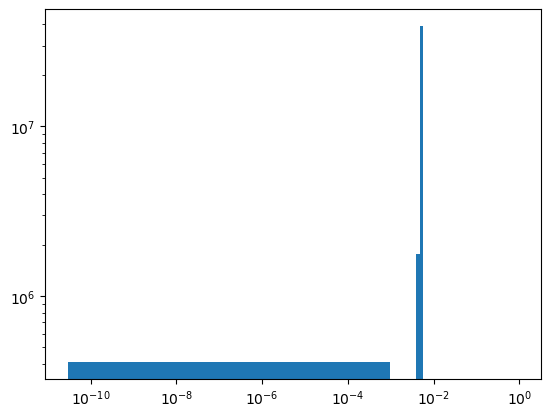

In [6]:
plt.hist(ca.rule.nearest_neighbours.reshape(-1).cpu().numpy(), 1000); plt.yscale('log'); plt.xscale('log')

In [7]:
plot1 = ca.rule.nearest_neighbours.reshape(1, 9, RESX, RESY).sum(dim=1).cpu().numpy()[0]
vmax=np.median(plot1) + np.std(plot1)
plt.imshow(plot1, vmax=vmax); plt.colorbar()

RuntimeError: shape '[1, 9, 640, 640]' is invalid for input of size 49561600

In [ ]:
plot2 = F.fold(ca.rule.nearest_neighbours, output_size=(RESX+2*RADIUS, RESY+2*RADIUS), kernel_size=(2*RADIUS + 1))[0, 0].cpu().numpy()

vmax=np.median(plot2) + np.std(plot2)
plt.imshow(plot2, vmax=vmax); plt.colorbar()

In [ ]:
state[:, [0], ...].shape

In [ ]:
ca.rule.nearest_neighbours.median()

In [ ]:
-(self.eps * self.nearest_neighbours * m ** 2)[0, :, 0].reshape(3, 3)

In [ ]:
dJ_hebb[0, :, 0].reshape(3, 3)

In [ ]:
new_J = new_J * (self.max_weight / new_J.abs().sum(dim=1, keepdim=True))

In [ ]:
new_J[0, :, 0].reshape(3, 3)

In [ ]:
new_J[0, :, 0].reshape(3, 3)

In [ ]:
ca.rule.nearest_neighbours[0, :, 0].reshape(3, 3)